# NLP Case Study on Depression Tweets

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

import pandas as pd
import numpy as np
import re

import nltk
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS

np.random.seed(2018)
from pprint import pprint

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r"C:\Notes\Semester 6\Natural Language Processing\Datasets\sentiment_tweets3.csv")
data.rename(columns = {'message to examine':'tweet', 'label (depression result)':'label'}, inplace = True)
data = data.sample(frac = 1)
data = data.reset_index()
data = data[['tweet', 'label']]
data.head()

,tweet,label
0,@rodjek Nothing leg warmers can't fix,0
1,Dinner on a rooftop garden with a view of the ...,0
2,"Mom's depression tied to kids' emotional, inte...",1
3,@THEROYALKOURT Hey congratulations on defeatin...,1
4,I added a video to a @YouTube playlist http:/...,1


## Preprocessing

In [3]:
#Removing null values
data=data.dropna()
data = data.reset_index(drop=True)
data

,tweet,label
0,@rodjek Nothing leg warmers can't fix,0
1,Dinner on a rooftop garden with a view of the ...,0
2,"Mom's depression tied to kids' emotional, inte...",1
3,@THEROYALKOURT Hey congratulations on defeatin...,1
4,I added a video to a @YouTube playlist http:/...,1
...,...,...
10309,@archiehamilton that's ok - Zeb copes well wit...,0
10310,post video game depression,1
10311,@kimkardashian http://twitpic.com/3gvq1 - You ...,0
10312,"@rhyzome the blog is pretty lame, but the stor...",0


In [4]:
#Lower casing
data['pre_process'] = data['tweet'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
data.head()

,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,@rodjek nothing leg warmers can't fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner on a rooftop garden with a view of the ...
2,"Mom's depression tied to kids' emotional, inte...",1,"mom's depression tied to kids' emotional, inte..."
3,@THEROYALKOURT Hey congratulations on defeatin...,1,@theroyalkourt hey congratulations on defeatin...
4,I added a video to a @YouTube playlist http:/...,1,i added a video to a @youtube playlist http://...


In [5]:
#Remove the HTML tags, URLs and usernames from the reviews.
data['pre_process']=data['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(r'http\S+', '', x))
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(r'@\S+', '', x))
data.head()

C:\Users\shahv\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,nothing leg warmers can't fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner on a rooftop garden with a view of the ...
2,"Mom's depression tied to kids' emotional, inte...",1,"mom's depression tied to kids' emotional, inte..."
3,@THEROYALKOURT Hey congratulations on defeatin...,1,hey congratulations on defeating your suicida...
4,I added a video to a @YouTube playlist http:/...,1,i added a video to a playlist funniest video...


In [6]:
#Removing word contractions
def contractions(s):
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s= re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    return s
data['pre_process']=data['pre_process'].apply(lambda x:contractions(x))
data.head()

,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,nothing leg warmers can not fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner on a rooftop garden with a view of the ...
2,"Mom's depression tied to kids' emotional, inte...",1,"mom is depression tied to kids' emotional, int..."
3,@THEROYALKOURT Hey congratulations on defeatin...,1,hey congratulations on defeating your suicida...
4,I added a video to a @YouTube playlist http:/...,1,i added a video to a playlist funniest video...


In [7]:
#Removing non-alpha characters
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
data.head()

,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,nothing leg warmers can not fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner on a rooftop garden with a view of the ...
2,"Mom's depression tied to kids' emotional, inte...",1,mom is depression tied to kids emotional int...
3,@THEROYALKOURT Hey congratulations on defeatin...,1,hey congratulations on defeating your suicidal...
4,I added a video to a @YouTube playlist http:/...,1,i added a video to a playlist funniest video ...


In [8]:
#Removing extra spaces
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(' +', ' ', x))
data.head()

,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,nothing leg warmers can not fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner on a rooftop garden with a view of the ...
2,"Mom's depression tied to kids' emotional, inte...",1,mom is depression tied to kids emotional intel...
3,@THEROYALKOURT Hey congratulations on defeatin...,1,hey congratulations on defeating your suicidal...
4,I added a video to a @YouTube playlist http:/...,1,i added a video to a playlist funniest video m...


In [9]:
#Removing stopwords
stop = stopwords.words('english')
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
data.head()

,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,nothing leg warmers fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner rooftop garden view sun setting mexico ...
2,"Mom's depression tied to kids' emotional, inte...",1,mom depression tied kids emotional intellectua...
3,@THEROYALKOURT Hey congratulations on defeatin...,1,hey congratulations defeating suicidal ideatio...
4,I added a video to a @YouTube playlist http:/...,1,added video playlist funniest video make fun t...


In [10]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
data.head()

,tweet,label,pre_process
0,@rodjek Nothing leg warmers can't fix,0,nothing leg warmer fix
1,Dinner on a rooftop garden with a view of the ...,0,dinner rooftop garden view sun setting mexico ...
2,"Mom's depression tied to kids' emotional, inte...",1,mom depression tied kid emotional intellectual...
3,@THEROYALKOURT Hey congratulations on defeatin...,1,hey congratulation defeating suicidal ideation...
4,I added a video to a @YouTube playlist http:/...,1,added video playlist funniest video make fun t...


## Descriptive Statistics

In [11]:
text = " ".join(review for review in data.pre_process)
split = text.split()

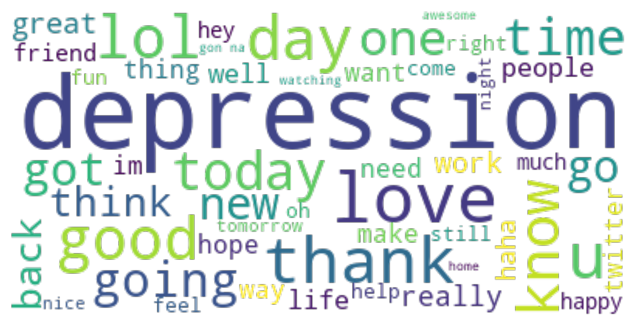

In [12]:
stopwords =  set(STOPWORDS)
stopwords.update(['movie', 'film', 'show', 'see', 'watch', 'seen', 'seem', 'say'])

#Generate a wordcloud image
wordcloud = WordCloud(mode = 'RGBA', max_font_size = 100, stopwords = stopwords, max_words = 50, 
                      background_color = None).generate(text)

#Display the generated image the matplotlib way
plt.imshow(wordcloud, interpolation = 'mitchell')
plt.axis('off')
plt.show()

In [13]:
#Frequency Distribution Table
freq_dist = nltk.FreqDist(split)
freq_dist = pd.DataFrame(freq_dist.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
freq_dist.head()

,word,frequency
17,depression,2331
64,good,699
101,day,693
55,love,582
81,like,567


<AxesSubplot:xlabel='frequency', ylabel='word'>

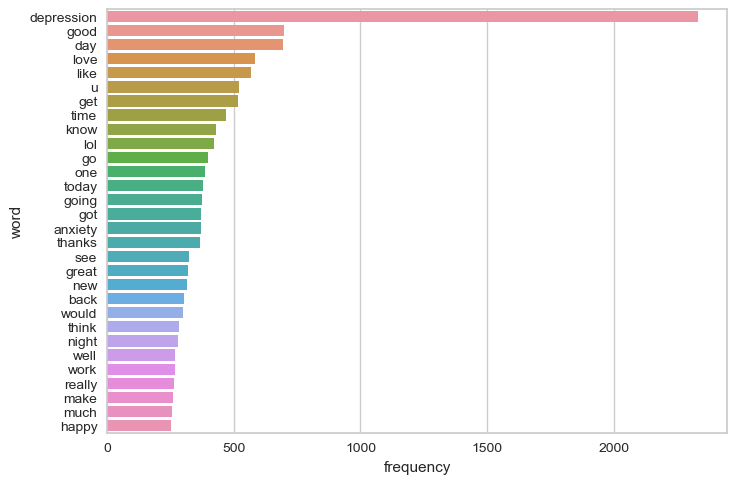

In [14]:
#Frequency Distribution Barplot
sns.barplot(x='frequency',y='word',data=freq_dist.head(30))

In [15]:
# WORD-COUNT
data['word_count'] = data['tweet'].apply(lambda x: len(str(x).split()))
print(data[data['label']==1]['word_count'].mean()) #Disaster tweets
print(data[data['label']==0]['word_count'].mean()) #Non-Disaster tweets

23.13180639585134
12.73625


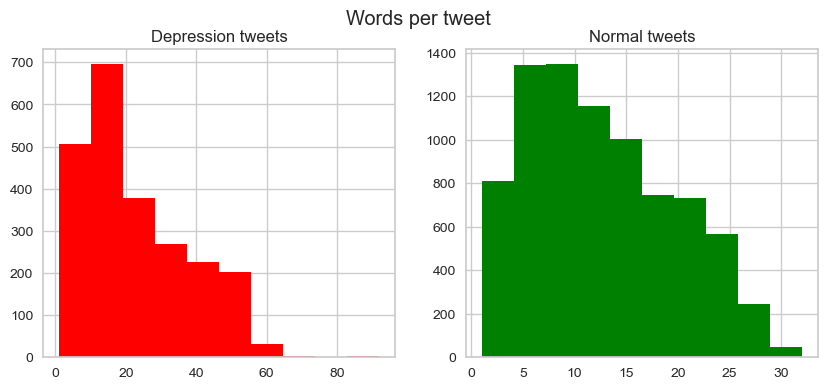

In [16]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['label']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Depression tweets')
train_words=data[data['label']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Normal tweets')
fig.suptitle('Words per tweet')
plt.show()

## Word Embedding (TF-IDF)

In [17]:
#Splitting into train and test datasets
x_train,x_test,y_train, y_test = train_test_split(data['pre_process'], data['label'], test_size=0.25, random_state=30)
print("Train: ",x_train.shape,x_train.shape,"Test: ",(x_test.shape,y_test.shape))

Train:  (7735,) (7735,) Test:  ((2579,), (2579,))


In [18]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(x_train)
tf_x_test = vectorizer.transform(x_test)
tf_x_train

<7735x11938 sparse matrix of type '<class 'numpy.float64'>'
	with 58300 stored elements in Compressed Sparse Row format>

## Classification

In [19]:
#Fitting the classification model using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(tf_x_train, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(tf_x_test)

y_prob = lr_tfidf.predict_proba(tf_x_test)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2033
           1       1.00      0.97      0.98       546

    accuracy                           0.99      2579
   macro avg       1.00      0.98      0.99      2579
weighted avg       0.99      0.99      0.99      2579

Confusion Matrix: [[2033    0]
 [  18  528]]
AUC: 0.9949473792316882


In [20]:
#Fitting the classification model using Naive Bayes(tf-idf)

nb_tfidf = MultinomialNB()

nb_tfidf.fit(tf_x_train, y_train)  

#Predict y value for test dataset

y_predict = nb_tfidf.predict(tf_x_test)

y_prob = nb_tfidf.predict_proba(tf_x_test)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2033
           1       0.98      0.60      0.75       546

    accuracy                           0.91      2579
   macro avg       0.94      0.80      0.85      2579
weighted avg       0.92      0.91      0.91      2579

Confusion Matrix: [[2028    5]
 [ 218  328]]
AUC: 0.9709009223273858


In [21]:
#Hence, logistic regression gives an accuracy score of 0.99. Thus, it is a better fit.

## Cluster Analysis

In [22]:
#Reading the reviews column into an array
documents = data.iloc[:,-2].tolist()
documents[:5]

['nothing leg warmer fix',
 'dinner rooftop garden view sun setting mexico city also sushi drink nice',
 'mom depression tied kid emotional intellectual development pictwittercompptaig',
 'hey congratulation defeating suicidal ideation severe depression stay strong keep fighting also congratulation intern ballin',
 'added video playlist funniest video make fun transgender crippling depression']

In [23]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

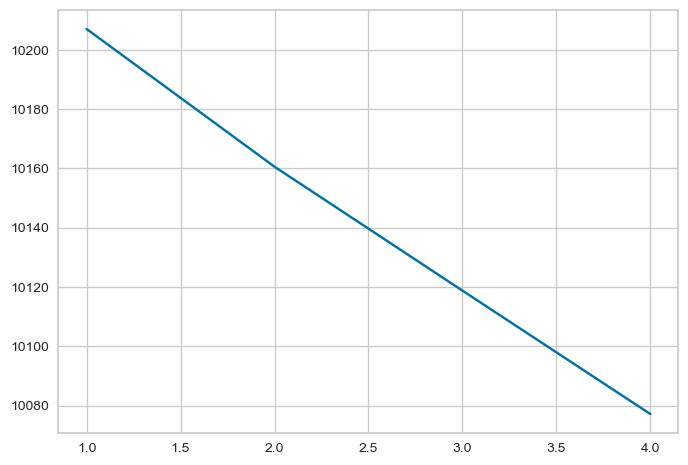

In [24]:
wcss=[]
for i in range(1,5):
    clustering = KMeans(n_clusters = i,init='k-means++',random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
ks = [1,2,3,4]
sns.lineplot(x = ks,y =wcss);

In [26]:
true_k = 2
model = KMeans(n_clusters = true_k, init='k-means++',max_iter = 100 , n_init = 1)
model.fit(X)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [57]:
print("Top terms per cluster :")
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i,:5]:
        print(' %s' % terms[ind]);
    print

Top terms per cluster :
Cluster 0:
 depression
 love
 thanks
 like
 get
Cluster 1:
 good
 day
 morning
 today
 night


# Topic Modelling

In [33]:
df=pd.DataFrame()
df['split'] = data['pre_process'].apply(lambda x: x.split())
df

,split
0,"[nothing, leg, warmer, fix]"
1,"[dinner, rooftop, garden, view, sun, setting, ..."
2,"[mom, depression, tied, kid, emotional, intell..."
3,"[hey, congratulation, defeating, suicidal, ide..."
4,"[added, video, playlist, funniest, video, make..."
...,...
10309,"[ok, zeb, cope, well, bossy, woman, english, c..."
10310,"[post, video, game, depression]"
10311,"[poor, thing, use, bronzer, still, look, great]"
10312,"[blog, pretty, lame, story, unreleased, bike, ..."


In [36]:
#Word Embedding on split text
#Creating a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set..

#Creating a vocabulary
dictionary = gensim.corpora.Dictionary(df['split'])

In [37]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 fix
1 leg
2 nothing
3 warmer
4 also
5 city
6 dinner
7 drink
8 garden
9 mexico
10 nice


In [38]:
#Doc2BOW
#Filtering out tokens that appear in less than 15 documents or more than 0.5 documents. After the above two steps, keeping only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)

In [40]:
#For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.
bow_corpus = [dictionary.doc2bow(doc) for doc in df['split']]
bow_corpus[4310]

[(50, 1), (87, 2), (244, 1), (590, 1)]

In [41]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 50 ("go") appears 1 time.
Word 87 ("computer") appears 2 time.
Word 244 ("want") appears 1 time.
Word 590 ("start") appears 1 time.


In [44]:
#Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6221554290764032), (1, 0.6277548712761466), (2, 0.46781026459433894)]


In [46]:
#LDA using BOW
#Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [47]:
#For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.060*"depression" + 0.028*"great" + 0.025*"day" + 0.017*"happy" + 0.014*"like" + 0.011*"watching" + 0.011*"think" + 0.010*"real" + 0.010*"oh" + 0.010*"hope"
Topic: 1 
Words: 0.033*"love" + 0.031*"today" + 0.023*"depression" + 0.020*"time" + 0.018*"na" + 0.017*"day" + 0.017*"one" + 0.017*"know" + 0.015*"go" + 0.013*"gon"
Topic: 2 
Words: 0.040*"depression" + 0.032*"day" + 0.029*"got" + 0.017*"get" + 0.016*"twitter" + 0.013*"today" + 0.013*"good" + 0.013*"well" + 0.011*"like" + 0.011*"make"
Topic: 3 
Words: 0.024*"thanks" + 0.020*"one" + 0.017*"depression" + 0.017*"work" + 0.015*"got" + 0.014*"haha" + 0.014*"back" + 0.014*"day" + 0.013*"im" + 0.012*"friend"
Topic: 4 
Words: 0.055*"depression" + 0.025*"new" + 0.018*"nice" + 0.014*"going" + 0.012*"like" + 0.012*"work" + 0.012*"watch" + 0.011*"time" + 0.011*"anxiety" + 0.011*"show"
Topic: 5 
Words: 0.132*"depression" + 0.026*"anxiety" + 0.016*"people" + 0.011*"get" + 0.011*"mental" + 0.011*"feel" + 0.010*"help" + 0.010*"re

In [48]:
#LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [49]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"well" + 0.012*"yes" + 0.011*"great" + 0.011*"time" + 0.010*"depression" + 0.010*"love" + 0.010*"come" + 0.010*"know" + 0.010*"guy" + 0.009*"good"
Topic: 1 Word: 0.022*"depression" + 0.019*"get" + 0.017*"anxiety" + 0.014*"today" + 0.014*"love" + 0.012*"thanks" + 0.012*"friend" + 0.012*"u" + 0.009*"going" + 0.009*"got"
Topic: 2 Word: 0.020*"depression" + 0.017*"go" + 0.011*"time" + 0.011*"job" + 0.010*"day" + 0.010*"need" + 0.009*"feel" + 0.008*"get" + 0.008*"tomorrow" + 0.008*"talk"
Topic: 3 Word: 0.017*"lol" + 0.014*"going" + 0.014*"night" + 0.012*"depression" + 0.011*"thanks" + 0.011*"good" + 0.011*"last" + 0.010*"time" + 0.009*"bed" + 0.008*"know"
Topic: 4 Word: 0.021*"thanks" + 0.020*"good" + 0.018*"morning" + 0.015*"day" + 0.015*"na" + 0.014*"yeah" + 0.013*"listening" + 0.011*"getting" + 0.010*"depression" + 0.010*"gon"
Topic: 5 Word: 0.058*"depression" + 0.017*"thank" + 0.013*"like" + 0.009*"oh" + 0.009*"new" + 0.009*"hey" + 0.009*"word" + 0.009*"next" + 0.00

In [54]:
#Performance evaluation by classifying sample document using LDA Bag of Words model
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.4408913850784302	 
Topic: 0.026*"know" + 0.026*"good" + 0.017*"come" + 0.016*"cool" + 0.015*"im" + 0.012*"check" + 0.010*"try" + 0.010*"haha" + 0.010*"even" + 0.010*"u"

Score: 0.4257352352142334	 
Topic: 0.035*"u" + 0.022*"like" + 0.017*"go" + 0.016*"thank" + 0.016*"depression" + 0.016*"would" + 0.014*"one" + 0.014*"new" + 0.014*"good" + 0.011*"tweet"

Score: 0.01667766459286213	 
Topic: 0.040*"depression" + 0.032*"day" + 0.029*"got" + 0.017*"get" + 0.016*"twitter" + 0.013*"today" + 0.013*"good" + 0.013*"well" + 0.011*"like" + 0.011*"make"

Score: 0.016673950478434563	 
Topic: 0.060*"good" + 0.035*"time" + 0.023*"get" + 0.018*"night" + 0.017*"morning" + 0.017*"depression" + 0.016*"day" + 0.012*"bed" + 0.011*"need" + 0.011*"go"

Score: 0.016671575605869293	 
Topic: 0.033*"love" + 0.031*"today" + 0.023*"depression" + 0.020*"time" + 0.018*"na" + 0.017*"day" + 0.017*"one" + 0.017*"know" + 0.015*"go" + 0.013*"gon"

Score: 0.016670819371938705	 
Topic: 0.055*"depression" + 0.025*"

In [55]:
#Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.49554282426834106	 
Topic: 0.021*"good" + 0.016*"morning" + 0.014*"welcome" + 0.014*"depression" + 0.011*"u" + 0.009*"world" + 0.009*"back" + 0.009*"kid" + 0.009*"cool" + 0.008*"tweet"

Score: 0.37106001377105713	 
Topic: 0.015*"well" + 0.012*"yes" + 0.011*"great" + 0.011*"time" + 0.010*"depression" + 0.010*"love" + 0.010*"come" + 0.010*"know" + 0.010*"guy" + 0.009*"good"

Score: 0.016680307686328888	 
Topic: 0.017*"good" + 0.014*"depression" + 0.010*"know" + 0.010*"great" + 0.010*"want" + 0.009*"like" + 0.009*"would" + 0.009*"twitter" + 0.009*"love" + 0.008*"one"

Score: 0.016678253188729286	 
Topic: 0.020*"depression" + 0.017*"go" + 0.011*"time" + 0.011*"job" + 0.010*"day" + 0.010*"need" + 0.009*"feel" + 0.008*"get" + 0.008*"tomorrow" + 0.008*"talk"

Score: 0.01667584665119648	 
Topic: 0.021*"thanks" + 0.020*"good" + 0.018*"morning" + 0.015*"day" + 0.015*"na" + 0.014*"yeah" + 0.013*"listening" + 0.011*"getting" + 0.010*"depression" + 0.010*"gon"

Score: 0.016673849895596504